In [21]:
import os # File system operations
import re # Regular expressions
import pandas as pd # Tabular data
import numpy as np # Numerical data
pd.set_option('display.max_colwidth', None) # Show full file paths

# Don't use all of the GPU RAM
import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
  tf.config.experimental.set_memory_growth(gpu, True)
from tensorflow import keras # ML
import tensorflow_addons as tfa # TQDM progress bar when training

BATCH_SIZE = 32

from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

from pathlib import Path # Pathing
from glob import glob # Finding files recursively
import matplotlib.pyplot as plt # Plotting
import seaborn as sns # Plotting
sns.set()
from tqdm.auto import tqdm # Progress bars
tqdm.pandas()

BASE_DIR = Path("EmbryoLabeling/Labelers/train")
folders = os.listdir(BASE_DIR)
folders = [f for f in folders if not re.match(r"M\d", f)]
files = []
for folder in folders:
    files_in_folder = pd.DataFrame(glob(f"{BASE_DIR}/{folder}/**/*.jpg", recursive=True), columns=["filename"])
    files_in_folder["class"] = folder
    files.append(files_in_folder)
df = pd.concat(files)
df["class"].value_counts()

Morula                 1319
2pn                    1039
Syngamy                 834
4 Cell                  792
2 Cell                  736
Compacting 8 cell       549
Expanded Blastocyst     394
8 Cell                  384
Blastocyst              374
6 Cell                  360
Cavitating morula       324
3 Cell                  303
Early blast             291
Name: class, dtype: int64

<AxesSubplot:>

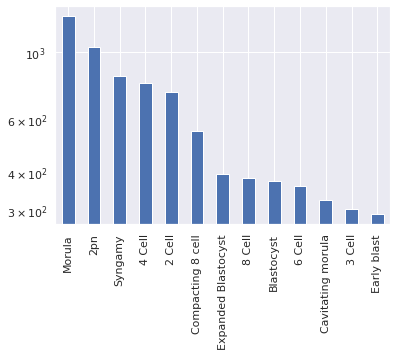

In [2]:
df["class"].value_counts().plot.bar(logy=True)

In [3]:
# Print counts of images by machine and slide
df.filename[~df["class"].isin(["bad", "Empty"])].apply(lambda s: s.split("/")[-1].split("_")[:2]).value_counts()

[M0776, S00512]    1896
[M776, S0087]      1520
[M0776, S00635]    1289
[M0776, S00761]    1111
[M0776, S00534]    1099
[M0776, S00470]     784
Name: filename, dtype: int64

In [4]:
# Track a single embryo's lifecycle
pd.set_option('display.max_rows', 365)
M776_S0087_W2 = df[df.filename.str.contains("M776_S0087_W2")].copy()
# Extract time since fertilisation in minutes from filename (ints, rounded to nearest minute)
M776_S0087_W2["time_since_fert"] = M776_S0087_W2.filename.apply(lambda s: s.replace(".jpg", "").split("_")[-1]).astype(int)
M776_S0087_W2 = M776_S0087_W2.sort_values(by="time_since_fert")
# Take the earliest time that each class was seen
M776_S0087_W2 = M776_S0087_W2.groupby("class").head(1)
print(M776_S0087_W2[["class", "time_since_fert"]])

                  class  time_since_fert
511                 2pn             1061
685             Syngamy             1464
298              2 Cell             1574
116              3 Cell             2315
104              4 Cell             2395
29               6 Cell             3125
145              8 Cell             3265
24    Compacting 8 cell             3375
1169             Morula             4286
199   Cavitating morula             5940
50          Early blast             6090
113          Blastocyst             6261


In [5]:
classes = list(M776_S0087_W2["class"])
classes

['2pn',
 'Syngamy',
 '2 Cell',
 '3 Cell',
 '4 Cell',
 '6 Cell',
 '8 Cell',
 'Compacting 8 cell',
 'Morula',
 'Cavitating morula',
 'Early blast',
 'Blastocyst']

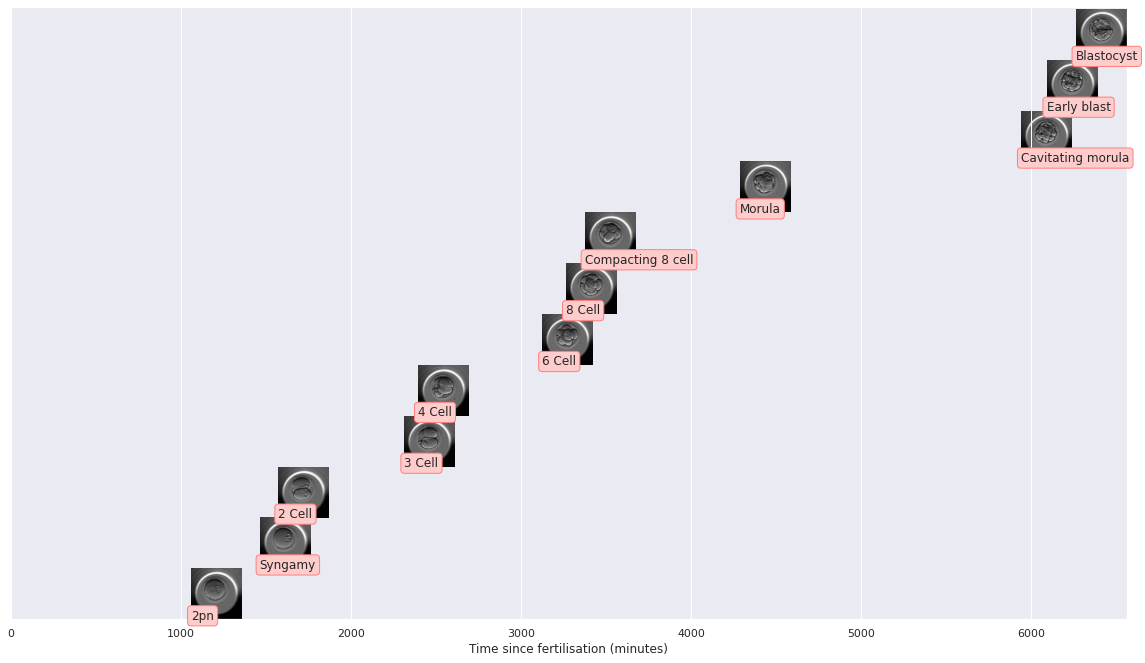

In [6]:
# Plot embryo's lifecycle over time
plt.figure(figsize=(20, 20))
for i, row in M776_S0087_W2.iterrows():
    image = keras.utils.load_img(row.filename, target_size=(299,299))
    c_index = classes.index(row["class"]) * 299
    time_since_fert = row.time_since_fert
    plt.imshow(image, extent=[time_since_fert, time_since_fert+299, c_index, c_index+299])
    plt.text(time_since_fert, c_index, row["class"], bbox=dict(boxstyle="round", ec=(1., 0.5, 0.5), fc=(1., 0.8, 0.8)))
plt.yticks([])
plt.xlabel("Time since fertilisation (minutes)")
plt.xlim(0, M776_S0087_W2.time_since_fert.max() + 300)
plt.ylim(0, len(classes) * 300)
plt.show()

In [7]:
class_counts = df["class"].value_counts()
mask = ~df["class"].isin(class_counts[class_counts > 10].index)
#df["class"][mask] = "Other"

In [8]:
#df["class"][~df["class"].isin(["Empty", "Morula"])] = "Other"
# Build training and validation dataframes. This gives us fine control over what we use for train & test
train_rows = []
validation_rows = []
for c in df["class"].unique():
    df_for_class = df[df["class"] == c].copy()
    if len(df_for_class) > 20:
        validation_sample = df_for_class.sample(round(.2*len(df_for_class)))
        validation_rows.append(validation_sample)
        train_sample = df_for_class.drop(validation_sample.index)
        # Accounting for training class imbalance
        # still leaving 20%. Might need more sophisticated f(x) here for class imbalance.
        train_sample = train_sample.sample(min(len(train_sample), round(.6*len(df_for_class))))
        train_rows.append(train_sample)
train_df = pd.concat(train_rows)
validation_df = pd.concat(validation_rows)
display(df)
display(train_df["class"].value_counts())
validation_df = validation_df.sample(frac=1)
display(validation_df["class"].value_counts())

,filename,class
0,EmbryoLabeling/Labelers/train/Expanded Blastocyst/M0776_S00512_W8_F0_6925.jpg,Expanded Blastocyst
1,EmbryoLabeling/Labelers/train/Expanded Blastocyst/M0776_S00534_W1_F0_7696.jpg,Expanded Blastocyst
2,EmbryoLabeling/Labelers/train/Expanded Blastocyst/M0776_S00761_W3_F0_6760.jpg,Expanded Blastocyst
3,EmbryoLabeling/Labelers/train/Expanded Blastocyst/M0776_S00512_W4_F0_6984.jpg,Expanded Blastocyst
4,EmbryoLabeling/Labelers/train/Expanded Blastocyst/M0776_S00761_W2_F0_6620.jpg,Expanded Blastocyst
...,...,...
731,EmbryoLabeling/Labelers/train/2 Cell/M0776_S00470_W3_F0_1654.jpg,2 Cell
732,EmbryoLabeling/Labelers/train/2 Cell/M0776_S00761_W1_F0_2267.jpg,2 Cell
733,EmbryoLabeling/Labelers/train/2 Cell/M776_S0087_W3_F0_1685.jpg,2 Cell
734,EmbryoLabeling/Labelers/train/2 Cell/M0776_S00470_W4_F0_1794.jpg,2 Cell


Morula                 791
2pn                    623
Syngamy                500
4 Cell                 475
2 Cell                 442
Compacting 8 cell      329
Expanded Blastocyst    236
8 Cell                 230
Blastocyst             224
6 Cell                 216
Cavitating morula      194
3 Cell                 182
Early blast            175
Name: class, dtype: int64

Morula                 264
2pn                    208
Syngamy                167
4 Cell                 158
2 Cell                 147
Compacting 8 cell      110
Expanded Blastocyst     79
8 Cell                  77
Blastocyst              75
6 Cell                  72
Cavitating morula       65
3 Cell                  61
Early blast             58
Name: class, dtype: int64

In [9]:
datagen = keras.preprocessing.image.ImageDataGenerator(rescale=1./255)
training = datagen.flow_from_dataframe(train_df, target_size=(299, 299), batch_size=BATCH_SIZE, shuffle=True)
# Don't shuffle validation, otherwise confusion_matrix won't work due to mismatch
validation = datagen.flow_from_dataframe(validation_df, target_size=(299, 299), batch_size=BATCH_SIZE, shuffle=False)

Found 4617 validated image filenames belonging to 13 classes.
Found 1541 validated image filenames belonging to 13 classes.


In [10]:
assert training.class_indices == validation.class_indices

In [11]:
list(training.class_indices.keys())

['2 Cell',
 '2pn',
 '3 Cell',
 '4 Cell',
 '6 Cell',
 '8 Cell',
 'Blastocyst',
 'Cavitating morula',
 'Compacting 8 cell',
 'Early blast',
 'Expanded Blastocyst',
 'Morula',
 'Syngamy']

In [12]:
code2class = {v:k for k, v in training.class_indices.items()}
code2class

{0: '2 Cell',
 1: '2pn',
 2: '3 Cell',
 3: '4 Cell',
 4: '6 Cell',
 5: '8 Cell',
 6: 'Blastocyst',
 7: 'Cavitating morula',
 8: 'Compacting 8 cell',
 9: 'Early blast',
 10: 'Expanded Blastocyst',
 11: 'Morula',
 12: 'Syngamy'}

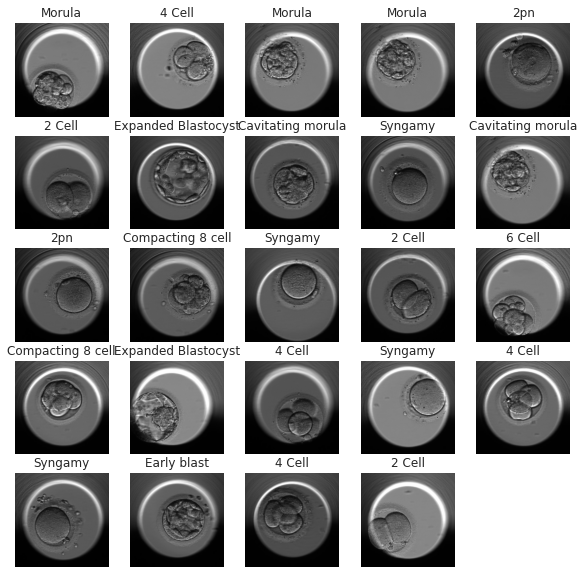

In [13]:
plt.figure(figsize=(10, 10))
images, labels = next(training)
for i in range(24):
    ax = plt.subplot(5, 5, i + 1)
    plt.imshow(images[i])
    plt.title(code2class[labels[i].argmax()])
    plt.axis("off")

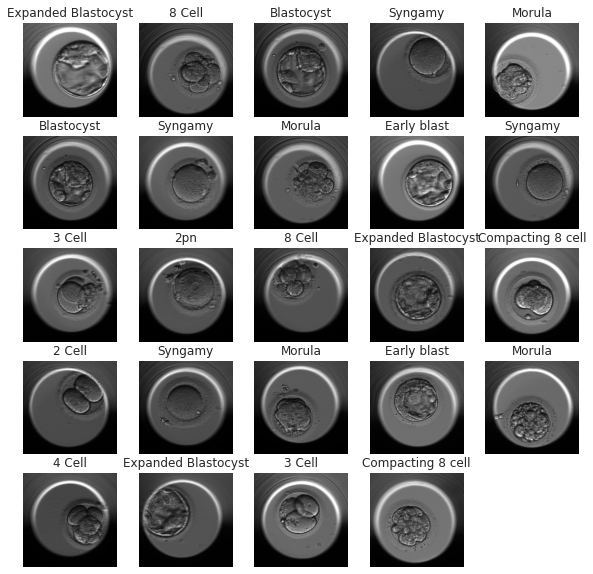

In [14]:
plt.figure(figsize=(10, 10))
images, labels = next(validation)
for i in range(min(24, len(labels))):
    ax = plt.subplot(5, 5, i + 1)
    plt.imshow(images[i])
    plt.title(code2class[labels[i].argmax()])
    plt.axis("off")

In [15]:
base_model = keras.applications.Xception(
    weights='imagenet',  # Load weights pre-trained on ImageNet.
    input_shape=(299, 299, 3),
    include_top=False)  # Do not include the ImageNet classifier at the top.

# Freeze the base_model
base_model.trainable = False

# Create new model on top
inputs = keras.Input(shape=(299, 299, 3))

# Pre-trained Xception weights requires that input be scaled
# from (0, 255) to a range of (-1., +1.), the rescaling layer
# outputs: `(inputs * scale) + offset`
scale_layer = keras.layers.Rescaling(scale=2, offset=-1)
x = scale_layer(inputs)

# The base model contains batchnorm layers. We want to keep them in inference mode
# when we unfreeze the base model for fine-tuning, so we make sure that the
# base_model is running in inference mode here.
x = base_model(x, training=False)
x = keras.layers.GlobalAveragePooling2D()(x)
#x = keras.layers.Dropout(0.2)(x)  # Regularize with dropout
outputs = keras.layers.Dense(len(code2class), activation='softmax')(x)
model = keras.Model(inputs, outputs)

model.summary()

2022-05-25 22:00:23.931286: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-05-25 22:00:23.932688: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-25 22:00:23.932899: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-25 22:00:23.933032: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA 

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 299, 299, 3)]     0         
                                                                 
 rescaling (Rescaling)       (None, 299, 299, 3)       0         
                                                                 
 xception (Functional)       (None, 10, 10, 2048)      20861480  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 13)                26637     
                                                                 
Total params: 20,888,117
Trainable params: 26,637
Non-trainable params: 20,861,480
____________________________________________

In [31]:
%%time
training.reset()
validation.reset()
model.compile(
    optimizer=keras.optimizers.Adam(),
    loss=keras.losses.CategoricalCrossentropy(),
    metrics=[keras.metrics.CategoricalAccuracy()],
)

history = model.fit(training,
                    epochs=500,
                    verbose=0, # TQDMProgressBar logs out the info, so no need for the default logs
                    validation_data=validation,
                    callbacks=[
                        keras.callbacks.EarlyStopping(patience=10, verbose=1),
                        tfa.callbacks.TQDMProgressBar()
                    ])

Training:   0%|           0/500 ETA: ?s,  ?epochs/s

Epoch 1/500


0/145           ETA: ?s - 

Epoch 2/500


0/145           ETA: ?s - 

Epoch 3/500


0/145           ETA: ?s - 

Epoch 4/500


0/145           ETA: ?s - 

Epoch 5/500


0/145           ETA: ?s - 

Epoch 6/500


0/145           ETA: ?s - 

Epoch 7/500


0/145           ETA: ?s - 

Epoch 8/500


0/145           ETA: ?s - 

Epoch 9/500


0/145           ETA: ?s - 

Epoch 10/500


0/145           ETA: ?s - 

Epoch 11/500


0/145           ETA: ?s - 

Epoch 12/500


0/145           ETA: ?s - 

Epoch 13/500


0/145           ETA: ?s - 

Epoch 14/500


0/145           ETA: ?s - 

Epoch 15/500


0/145           ETA: ?s - 

Epoch 16/500


0/145           ETA: ?s - 

Epoch 17/500


0/145           ETA: ?s - 

Epoch 18/500


0/145           ETA: ?s - 

Epoch 19/500


0/145           ETA: ?s - 

Epoch 20/500


0/145           ETA: ?s - 

Epoch 21/500


0/145           ETA: ?s - 

Epoch 22/500


0/145           ETA: ?s - 

Epoch 23/500


0/145           ETA: ?s - 

Epoch 24/500


0/145           ETA: ?s - 

Epoch 25/500


0/145           ETA: ?s - 

Epoch 26/500


0/145           ETA: ?s - 

Epoch 27/500


0/145           ETA: ?s - 

Epoch 28/500


0/145           ETA: ?s - 

Epoch 29/500


0/145           ETA: ?s - 

Epoch 30/500


0/145           ETA: ?s - 

Epoch 31/500


0/145           ETA: ?s - 

Epoch 32/500


0/145           ETA: ?s - 

Epoch 33/500


0/145           ETA: ?s - 

Epoch 34/500


0/145           ETA: ?s - 

Epoch 35/500


0/145           ETA: ?s - 

Epoch 36/500


0/145           ETA: ?s - 

Epoch 37/500


0/145           ETA: ?s - 

Epoch 38/500


0/145           ETA: ?s - 

Epoch 39/500


0/145           ETA: ?s - 

Epoch 40/500


0/145           ETA: ?s - 

Epoch 41/500


0/145           ETA: ?s - 

Epoch 42/500


0/145           ETA: ?s - 

Epoch 43/500


0/145           ETA: ?s - 

Epoch 44/500


0/145           ETA: ?s - 

Epoch 45/500


0/145           ETA: ?s - 

Epoch 46/500


0/145           ETA: ?s - 

Epoch 47/500


0/145           ETA: ?s - 

Epoch 48/500


0/145           ETA: ?s - 

Epoch 49/500


0/145           ETA: ?s - 

Epoch 50/500


0/145           ETA: ?s - 

Epoch 51/500


0/145           ETA: ?s - 

Epoch 52/500


0/145           ETA: ?s - 

Epoch 53/500


0/145           ETA: ?s - 

Epoch 54/500


0/145           ETA: ?s - 

Epoch 55/500


0/145           ETA: ?s - 

Epoch 56/500


0/145           ETA: ?s - 

Epoch 57/500


0/145           ETA: ?s - 

Epoch 58/500


0/145           ETA: ?s - 

Epoch 58: early stopping
CPU times: user 23min 12s, sys: 9min 16s, total: 32min 28s
Wall time: 26min 21s


<AxesSubplot:>

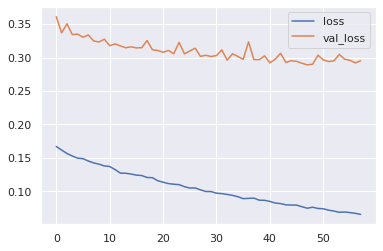

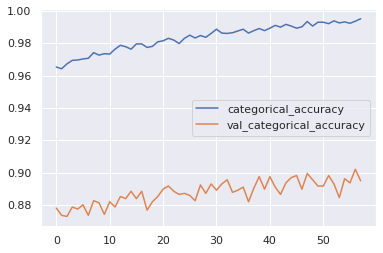

In [32]:
history_df = pd.DataFrame(history.history)
history_df[['loss', 'val_loss']].plot()
history_df[['categorical_accuracy', 'val_categorical_accuracy']].plot()

In [33]:
validation.reset()
print("True:", validation.labels)
print("Predictions: ", model.predict(validation).argmax(axis=1))

True: [10, 5, 6, 12, 11, 6, 12, 11, 9, 12, 2, 1, 5, 10, 8, 0, 12, 11, 9, 11, 3, 10, 2, 8, 0, 5, 7, 11, 5, 6, 0, 2, 2, 8, 11, 1, 12, 7, 1, 3, 10, 1, 1, 1, 12, 5, 3, 8, 12, 11, 1, 10, 8, 1, 5, 9, 11, 11, 12, 12, 4, 8, 1, 12, 11, 10, 1, 0, 0, 2, 12, 11, 12, 2, 11, 11, 12, 12, 8, 8, 0, 8, 4, 1, 11, 3, 12, 11, 1, 1, 10, 0, 5, 11, 8, 1, 1, 9, 10, 1, 7, 4, 11, 6, 2, 11, 3, 1, 11, 5, 12, 3, 4, 0, 7, 11, 10, 5, 1, 1, 7, 3, 7, 10, 6, 11, 10, 1, 3, 3, 1, 12, 1, 7, 3, 1, 7, 10, 4, 3, 8, 5, 3, 7, 3, 0, 11, 3, 5, 9, 1, 0, 11, 8, 12, 1, 11, 11, 11, 4, 11, 9, 8, 1, 7, 9, 0, 1, 10, 3, 12, 11, 9, 12, 8, 2, 8, 1, 11, 8, 3, 5, 11, 11, 12, 1, 0, 1, 11, 3, 1, 4, 0, 11, 5, 8, 1, 1, 3, 11, 3, 8, 1, 0, 3, 11, 10, 1, 3, 6, 11, 3, 0, 9, 11, 11, 9, 12, 1, 0, 8, 3, 2, 4, 0, 11, 10, 3, 7, 3, 3, 5, 0, 6, 10, 8, 1, 5, 1, 11, 0, 11, 3, 3, 11, 0, 7, 5, 12, 3, 2, 11, 8, 10, 2, 11, 11, 4, 1, 1, 8, 11, 11, 6, 7, 1, 1, 5, 12, 1, 7, 0, 3, 5, 3, 12, 11, 9, 3, 11, 4, 3, 6, 12, 11, 11, 0, 2, 4, 0, 2, 1, 9, 1, 12, 11, 12, 1, 6,

In [34]:
y_pred = model.predict(validation)

In [35]:
predicted_codes = y_pred.argmax(axis=1)
confidence = pd.Series(y_pred.max(axis=1))
confidence.describe()

count    1541.000000
mean        0.902407
std         0.145392
min         0.326731
25%         0.867170
50%         0.977914
75%         0.996710
max         0.999996
dtype: float64

In [36]:
validation_df["predicted_class"] = [code2class[c] for c in predicted_codes]
validation_df["confidence"] = confidence
validation_df

,filename,class,predicted_class,confidence
384,EmbryoLabeling/Labelers/train/Expanded Blastocyst/M776_S0087_W6_F0_6131.jpg,Expanded Blastocyst,Expanded Blastocyst,0.999952
111,EmbryoLabeling/Labelers/train/8 Cell/M0776_S00534_W3_F0_2969.jpg,8 Cell,8 Cell,0.997287
196,EmbryoLabeling/Labelers/train/Blastocyst/M0776_S00512_W3_F0_6621.jpg,Blastocyst,Blastocyst,0.996172
628,EmbryoLabeling/Labelers/train/Syngamy/M0776_S00761_W1_F0_1406.jpg,Syngamy,Syngamy,0.980029
117,EmbryoLabeling/Labelers/train/Morula/M776_S0087_W4_F0_5256.jpg,Morula,Morula,0.987675
...,...,...,...,...
346,EmbryoLabeling/Labelers/train/2 Cell/M776_S0087_W3_F0_2095.jpg,2 Cell,2 Cell,0.786259
1176,EmbryoLabeling/Labelers/train/Morula/M0776_S00534_W4_F0_5713.jpg,Morula,Morula,0.999995
65,EmbryoLabeling/Labelers/train/6 Cell/M0776_S00512_W4_F0_3032.jpg,6 Cell,6 Cell,0.920581
335,EmbryoLabeling/Labelers/train/Compacting 8 cell/M0776_S00534_W4_F0_4782.jpg,Compacting 8 cell,Compacting 8 cell,0.986113


In [37]:
validation_df.groupby("class").confidence.median()

class
2 Cell                 0.978290
2pn                    0.966910
3 Cell                 0.987228
4 Cell                 0.978099
6 Cell                 0.975055
8 Cell                 0.977481
Blastocyst             0.978256
Cavitating morula      0.970853
Compacting 8 cell      0.977423
Early blast            0.983354
Expanded Blastocyst    0.970853
Morula                 0.976336
Syngamy                0.980754
Name: confidence, dtype: float32

In [38]:
validation_df.to_csv("validation_predictions.csv", index=False)

                     precision    recall  f1-score   support

             2 Cell       0.89      0.95      0.92       147
                2pn       0.95      0.91      0.93       208
             3 Cell       0.90      0.87      0.88        61
             4 Cell       0.97      0.96      0.97       158
             6 Cell       0.96      0.93      0.94        72
             8 Cell       0.83      0.91      0.87        77
         Blastocyst       0.78      0.76      0.77        75
  Cavitating morula       0.87      0.63      0.73        65
  Compacting 8 cell       0.91      0.75      0.82       110
        Early blast       0.73      0.76      0.75        58
Expanded Blastocyst       0.91      0.92      0.92        79
             Morula       0.85      0.96      0.90       264
            Syngamy       0.94      0.94      0.94       167

           accuracy                           0.89      1541
          macro avg       0.88      0.87      0.87      1541
       weighted avg   

Text(30.499999999999993, 0.5, 'True')

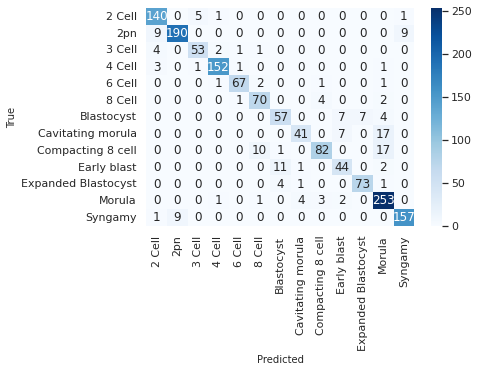

In [39]:
print(classification_report(validation_df["class"], validation_df["predicted_class"]))
labels = list(training.class_indices.keys())
s = sns.heatmap(
    confusion_matrix(validation_df["class"], validation_df["predicted_class"]),
    annot=True,
    cmap='Blues',
    fmt="g",
    xticklabels=labels,
    yticklabels=labels
)
s.set_xlabel('Predicted', fontsize=10)
s.set_ylabel('True', fontsize=10)

In [40]:
model.save(f"models/{len(code2class)}_class.h5")

In [41]:
# Make some predictions on unlabelled data
folders = os.listdir("EmbryoLabeling/Labelers/One")
folders = [f for f in folders if re.match(r"M\d", f)]
files = []
for folder in folders:
    files_in_folder = pd.DataFrame(glob(f"EmbryoLabeling/Labelers/One/{folder}/**/*.jpg", recursive=True), columns=["filename"])
    files_in_folder["class"] = "unknown"
    files.append(files_in_folder)
test_df = pd.concat(files)
test_df

,filename,class
0,EmbryoLabeling/Labelers/One/M3169_S00470/M3169_S00470_W1_F0_1516.jpg,unknown
1,EmbryoLabeling/Labelers/One/M3169_S00470/M3169_S00470_W7_F0_9023.jpg,unknown
2,EmbryoLabeling/Labelers/One/M3169_S00470/M3169_S00470_W4_F0_9524.jpg,unknown
3,EmbryoLabeling/Labelers/One/M3169_S00470/M3169_S00470_W2_F0_8369.jpg,unknown
4,EmbryoLabeling/Labelers/One/M3169_S00470/M3169_S00470_W7_F0_9589.jpg,unknown
...,...,...
4046,EmbryoLabeling/Labelers/One/M0831_S00534/M0831_S00534_W12_F0_998.jpg,unknown
4047,EmbryoLabeling/Labelers/One/M0831_S00534/M0831_S00534_W5_F0_3216.jpg,unknown
4048,EmbryoLabeling/Labelers/One/M0831_S00534/M0831_S00534_W12_F0_4793.jpg,unknown
4049,EmbryoLabeling/Labelers/One/M0831_S00534/M0831_S00534_W3_F0_3916.jpg,unknown


In [48]:
class TQDMPredictCallback(keras.callbacks.Callback):
    def __init__(self, custom_tqdm_instance=None, tqdm_cls=tqdm, **tqdm_params):
        super().__init__()
        self.tqdm_cls = tqdm_cls
        self.tqdm_progress = None
        self.prev_predict_batch = None
        self.custom_tqdm_instance = custom_tqdm_instance
        self.tqdm_params = tqdm_params

    def on_predict_batch_begin(self, batch, logs=None):
        pass

    def on_predict_batch_end(self, batch, logs=None):
        self.tqdm_progress.update(batch - self.prev_predict_batch)
        self.prev_predict_batch = batch

    def on_predict_begin(self, logs=None):
        self.prev_predict_batch = 0
        if self.custom_tqdm_instance:
            self.tqdm_progress = self.custom_tqdm_instance
            return

        total = self.params.get('steps')
        if total:
            total -= 1

        self.tqdm_progress = self.tqdm_cls(total=total, **self.tqdm_params)

    def on_predict_end(self, logs=None):
        if self.tqdm_progress and not self.custom_tqdm_instance:
            self.tqdm_progress.close()

test = datagen.flow_from_dataframe(test_df, target_size=(299, 299), batch_size=BATCH_SIZE, shuffle=False)
results = model.predict(test, callbacks=[TQDMPredictCallback()])

Found 26557 validated image filenames belonging to 13 classes.


  0%|          | 0/829 [00:00<?, ?it/s]

In [49]:
predicted_codes = results.argmax(axis=1)
confidence = pd.Series(results.max(axis=1))
confidence.describe()

count    26557.000000
mean         0.801773
std          0.195785
min          0.145600
25%          0.649774
50%          0.871860
75%          0.978968
max          1.000000
dtype: float64

In [50]:
test_df["class"] = [code2class[c] for c in predicted_codes]
test_df["confidence"] = confidence

In [51]:
test_df["class"].value_counts()

2pn                    8975
Morula                 3780
Expanded Blastocyst    3455
Syngamy                3241
Compacting 8 cell      2300
4 Cell                 1756
2 Cell                  877
Cavitating morula       555
Early blast             471
Blastocyst              431
8 Cell                  261
3 Cell                  234
6 Cell                  221
Name: class, dtype: int64

In [52]:
test_df

,filename,class,confidence
0,EmbryoLabeling/Labelers/One/M3169_S00470/M3169_S00470_W1_F0_1516.jpg,Syngamy,0.563421
1,EmbryoLabeling/Labelers/One/M3169_S00470/M3169_S00470_W7_F0_9023.jpg,2pn,0.786004
2,EmbryoLabeling/Labelers/One/M3169_S00470/M3169_S00470_W4_F0_9524.jpg,Expanded Blastocyst,0.836129
3,EmbryoLabeling/Labelers/One/M3169_S00470/M3169_S00470_W2_F0_8369.jpg,4 Cell,0.925235
4,EmbryoLabeling/Labelers/One/M3169_S00470/M3169_S00470_W7_F0_9589.jpg,2pn,0.554360
...,...,...,...
4046,EmbryoLabeling/Labelers/One/M0831_S00534/M0831_S00534_W12_F0_998.jpg,2pn,0.852575
4047,EmbryoLabeling/Labelers/One/M0831_S00534/M0831_S00534_W5_F0_3216.jpg,4 Cell,0.957446
4048,EmbryoLabeling/Labelers/One/M0831_S00534/M0831_S00534_W12_F0_4793.jpg,Morula,0.931750
4049,EmbryoLabeling/Labelers/One/M0831_S00534/M0831_S00534_W3_F0_3916.jpg,Compacting 8 cell,0.362020


In [53]:
test_df.to_csv("predictions.csv", index=False)